In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb


# Preprocesamiento de los datos

In [73]:
# Cargar datos
real_data = pd.read_csv('pb_inputs_real_dia.csv', parse_dates=['Fecha'], index_col='Fecha')
forecast_data = pd.read_csv('pb_inputs_frcst_dia.csv', parse_dates=['Fecha'], index_col='Fecha')

# cambio de formato
real_data = real_data.apply(lambda x: x.astype(str).str.replace(',', '').astype(float))
forecast_data = forecast_data.apply(lambda x: x.astype(str).str.replace(',', '').astype(float))

# Asegurar frecuencia diaria
real_data = real_data.asfreq('D')
forecast_data = forecast_data.asfreq('D')

# Verificar que el dataframe contiene datos desde 2000 hasta la fecha actual
fecha_inicio = '2000-01-01'
fecha_fin = '2025-12-31'
real_data = real_data.reindex(pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D'))

# Rellenar valores faltantes en variables exógenas (ONI proyectado)
real_data['ONI'].fillna(method='ffill', inplace=True)

# Unir datos reales y proyectados
full_data = real_data.copy()
full_data.update(forecast_data)

# Dividir en entrenamiento y prueba
train = real_data[:'2024-12-31']
test = real_data['2025-01-01':'2025-01-31']

# Definir variables predictoras y objetivo
features = ['ONI', 'Demanda Comercial']  # Agrega más si es necesario
target = 'Precio Bolsa Nacional'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

/var/folders/pr/tx2ysvjn2f1cnrmlf2p7ktjh0000gn/T/ipykernel_4986/3483855445.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  real_data['ONI'].fillna(method='ffill', inplace=True)
/var/folders/pr/tx2ysvjn2f1cnrmlf2p7ktjh0000gn/T/ipykernel_4986/3483855445.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  real_data['ONI'].fillna(method='ffill', inplace=True)


# Modelamiento Inicial

0
0
                             MSE        RMSE      MAPE
Linear Regression   61679.905464  248.354395  0.386565
Random Forest      102905.090170  320.788233  0.528618
XGBoost            131506.979163  362.638910  0.579410


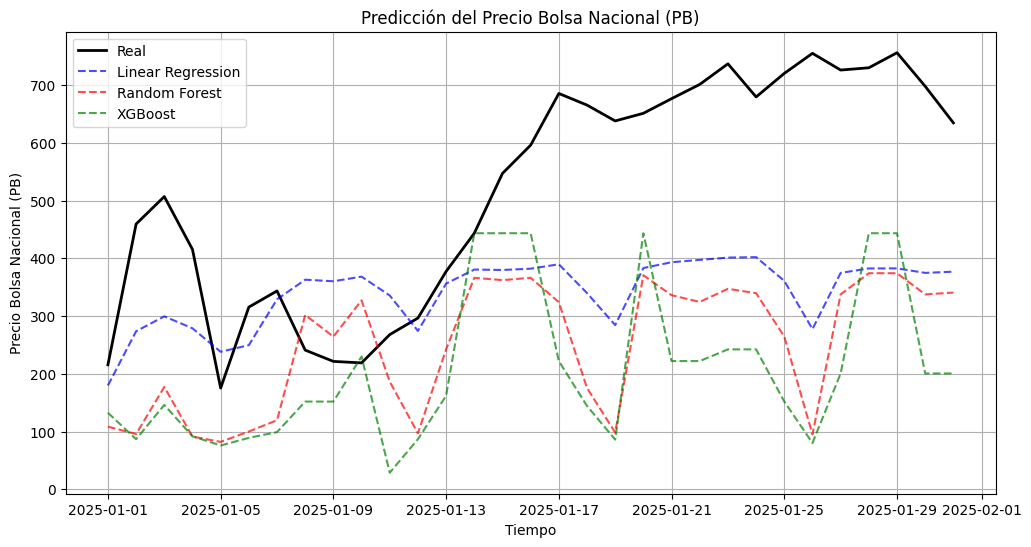

In [74]:
# Modelos
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# verificación de NaNs en los sets de entrenamiento y prueba
print(X_train.isna().sum().sum())  # Cantidad total de NaNs en X_train
print(X_test.isna().sum().sum())   # Cantidad total de NaNs en X_test

# Entrenamiento y predicción
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = y_pred

# Evaluación
metrics = {}
for name, y_pred in results.items():
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    metrics[name] = {'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

eval_df = pd.DataFrame(metrics).T
print(eval_df)



plt.figure(figsize=(12, 6))

# Eje X corregido (si test.index no es de fechas, usa un rango)
x_axis = test.index if hasattr(test, 'index') else range(len(y_test))

# Gráfico del valor real
plt.plot(x_axis, y_test, label='Real', color='black', linewidth=2)

# Gráfico de cada modelo con colores y transparencias distintas
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, (name, y_pred) in enumerate(results.items()):
    plt.plot(x_axis, y_pred, label=name, linestyle='dashed', color=colors[i % len(colors)], alpha=0.7)

plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Precio Bolsa Nacional (PB)")
plt.title("Predicción del Precio Bolsa Nacional (PB)")
plt.grid(True)  # Añadir rejilla para mejor visibilidad
plt.show()

# Modelamiento con Optimización de Hiperparámetros

Mejores parámetros para Random Forest: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None, 'bootstrap': True}
Mejores parámetros para XGBoost: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
                        MSE       RMSE      MAPE
Random Forest  76709.511756  276.96482  0.485745
XGBoost        49796.962519  223.15233  0.381697


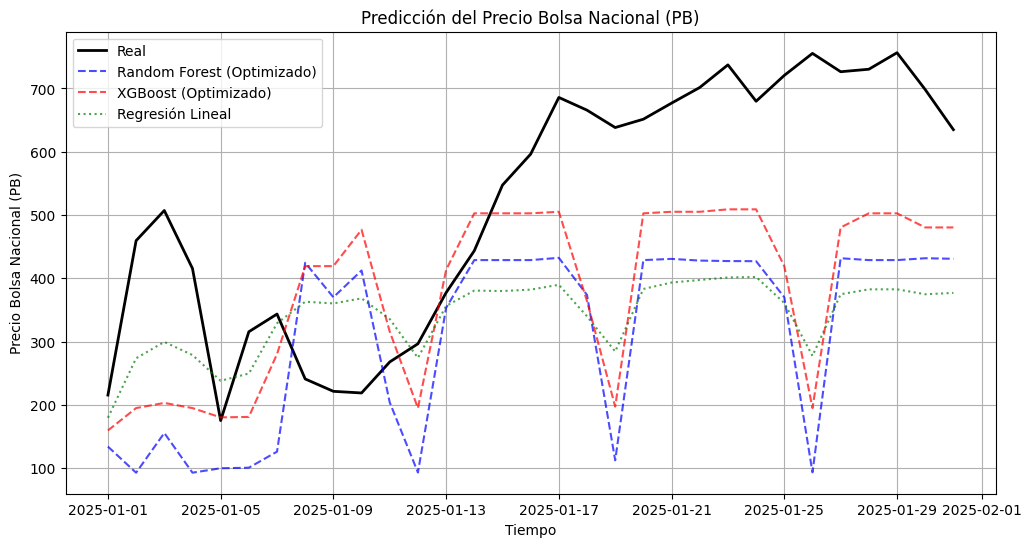

In [75]:
# Espacios de búsqueda de hiperparámetros
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Modelos base
rf = RandomForestRegressor(random_state=42)
xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Optimización con RandomizedSearchCV
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=20, cv=3, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
xgb_search = RandomizedSearchCV(xgbr, xgb_params, n_iter=20, cv=3, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

# Ajustar modelos
rf_search.fit(X_train, y_train)
xgb_search.fit(X_train, y_train)

# Mostrar mejores hiperparámetros
print("Mejores parámetros para Random Forest:", rf_search.best_params_)
print("Mejores parámetros para XGBoost:", xgb_search.best_params_)

# Evaluación con los mejores modelos
best_rf = rf_search.best_estimator_
best_xgb = xgb_search.best_estimator_

y_pred_rf = best_rf.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)

# Calcular métricas
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_mape = mean_absolute_percentage_error(y_test, y_pred_rf)

xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mape = mean_absolute_percentage_error(y_test, y_pred_xgb)

# Mostrar resultados mejorados
optimized_metrics = pd.DataFrame({
    "Random Forest": {"MSE": rf_mse, "RMSE": rf_rmse, "MAPE": rf_mape},
    "XGBoost": {"MSE": xgb_mse, "RMSE": xgb_rmse, "MAPE": xgb_mape}
}).T

print(optimized_metrics)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Eje X corregido (si test.index no es de fechas, usa un rango)
x_axis = test.index if hasattr(test, 'index') else range(len(y_test))

# Gráfico del valor real
plt.plot(x_axis, y_test, label='Real', color='black', linewidth=2)

# Gráfico de predicciones optimizadas
plt.plot(x_axis, y_pred_rf, label="Random Forest (Optimizado)", linestyle='dashed', color='blue', alpha=0.7)
plt.plot(x_axis, y_pred_xgb, label="XGBoost (Optimizado)", linestyle='dashed', color='red', alpha=0.7)

# Gráfico de predicción con Regresión Lineal inicial
plt.plot(x_axis, results['Linear Regression'], label="Regresión Lineal", linestyle='dotted', color='green', alpha=0.7)

plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Precio Bolsa Nacional (PB)")
plt.title("Predicción del Precio Bolsa Nacional (PB)")
plt.grid(True)  # Añadir rejilla para mejor visibilidad
plt.show()


In [76]:
forecast_df = pd.DataFrame({
    'Fecha': test.index,  # Asegura que test.index tenga fechas, si no, usa range(len(y_test))
    'Real': y_test,
    'Regresión Lineal': results['Linear Regression'],
    'Random Forest (Optimizado)': y_pred_rf,
    'XGBoost (Optimizado)': y_pred_xgb
})

# Exportar a CSV
forecast_df.to_csv("predicciones_PB.csv", index=False, encoding='utf-8')

print("Archivo 'predicciones_PB.csv' exportado con éxito.")

Archivo 'predicciones_PB.csv' exportado con éxito.


In [77]:
forecast_df

,Fecha,Real,Regresión Lineal,Random Forest (Optimizado),XGBoost (Optimizado)
2025-01-01,2025-01-01,215.5941,179.742182,134.197982,159.676804
2025-01-02,2025-01-02,459.5181,273.694119,92.923847,195.020447
2025-01-03,2025-01-03,507.1388,299.554338,155.678590,203.187256
2025-01-04,2025-01-04,415.5684,278.828925,92.988863,195.020447
2025-01-05,2025-01-05,175.3064,238.145708,99.991226,180.324158
2025-01-06,2025-01-06,315.5946,249.617363,100.830122,181.080353
2025-01-07,2025-01-07,343.5565,328.971685,126.194330,280.319336
2025-01-08,2025-01-08,241.0370,363.053474,424.595306,419.260010
2025-01-09,2025-01-09,221.4987,360.365213,370.090169,419.260010
2025-01-10,2025-01-10,218.9209,368.371200,412.403964,476.736755
